<a href="https://colab.research.google.com/github/jayyanar/agentic-ai-training/blob/lab-day-1/batch2/lca-langchainV1-essentials/mandatory/output/L1_fast_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast Agent - Build a SQL Agent fast!

<img src="https://github.com/jayyanar/agentic-ai-training/blob/lab-day-1/batch2/lca-langchainV1-essentials/assets/LC_L1_Top.png?raw=1" align="left" width="500">

## Setup

Load and/or check for needed environmental variables

What we're doing: Install required packages for the Colab session.

In [1]:
!pip install -qU langchain-groq langgraph langchain-community pysqlite3-binary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.4/157.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 1.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


What we're doing: Load the GROQ API key from Colab userdata into the environment.

In [2]:
from google.colab import userdata
import os

os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')

What we're doing: Connect to the sample SQLite database and list available tables.

In [3]:
from langchain_community.utilities import SQLDatabase

# Download the database file locally
!wget -q https://github.com/jayyanar/agentic-ai-training/raw/lab-day-1/batch2/lca-langchainV1-essentials/Chinook.db

# Update the URI to the local path
db = SQLDatabase.from_uri("sqlite:///Chinook.db")

# Verify it works
print(db.get_usable_table_names())

['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


Define the runtime context to provide the agent and tools with access to the database.

What we're doing: Define a `RuntimeContext` dataclass to hold runtime resources like the database.

In [4]:
from dataclasses import dataclass

from langchain_community.utilities import SQLDatabase


# define context structure to support dependency injection
@dataclass
class RuntimeContext:
    db: SQLDatabase

<b>⚠️ Security Note:</b> This demo does not include a filter on LLM-generated commands. In production, you would want to limit the scope of LLM-generated commands. ⚠️   
This tool will connect to the database. Note the use of `get_runtime` to access the graph **runtime context**.

What we're doing: Define a `execute_sql` tool that agents can call to run read-only SQL queries.

In [5]:
from langchain_core.tools import tool
from langgraph.runtime import get_runtime

@tool
def execute_sql(query: str) -> str:
    """Execute a SQLite command and return results."""
    runtime = get_runtime(RuntimeContext)
    db = runtime.context.db

    try:
        return db.run(query)
    except Exception as e:
        return f"Error: {e}"

Add a system prompt to define your agents behavior.

What we're doing: Define the `SYSTEM_PROMPT` that constrains the agent's SQL behavior and safety rules.

In [6]:
SYSTEM_PROMPT = """You are a careful SQLite analyst.

Rules:
- Think step-by-step.
- When you need data, call the tool `execute_sql` with ONE SELECT query.
- Read-only only; no INSERT/UPDATE/DELETE/ALTER/DROP/CREATE/REPLACE/TRUNCATE.
- Limit to 5 rows of output unless the user explicitly asks otherwise.
- If the tool returns 'Error:', revise the SQL and try again.
- Prefer explicit column lists; avoid SELECT *.
"""

Create your agent! Add a model, tools, a prompt, and the runtime access, and go!  You can choose many agents from our [integrations](https://docs.langchain.com/oss/python/integrations/providers) list.

What we're doing: Initialize the Groq LLM and create an agent wired to the `execute_sql` tool and runtime context.

In [7]:
from langchain.agents import create_agent
from langchain_groq import ChatGroq

""" agent = create_agent(
    model="openai:gpt-5-mini",
    tools=[execute_sql],
    system_prompt=SYSTEM_PROMPT,
    context_schema=RuntimeContext,
) """

# Initialize the Groq model
llm = ChatGroq(
    model="openai/gpt-oss-120b",
    temperature=0,
    max_retries=2,
)

# Use the llm object in the agent creation
agent = create_agent(
    model=llm,
    tools=[execute_sql],
    system_prompt=SYSTEM_PROMPT,
    context_schema=RuntimeContext,
)

Here's a display of the agent ReAct Loop.

What we're doing: Display the agent's internal ReAct loop graph for inspection.

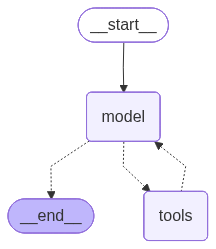

In [8]:
from IPython.display import Image, display

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

Run some queries. Notice:
- The agent does not have the database schema and will need to discover it independently.
- The agent may make mistakes! By returning error messages, the agent can self-correct its queries.
- Notice you invoke the agent with `agent.stream`.
    - This command and the `pretty_print` display the **messages** that communicate information between the model and the tools.
- Notice the agent doesn't remember the schema between invocations... More on this later!

What we're doing: Ask the agent a question about the database and stream its step-by-step responses.

In [9]:
question = "Which table has the largest number of entries?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which table has the largest number of entries?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (fc_311e6419-56c7-42dd-a61e-b22525ab10c4)
 Call ID: fc_311e6419-56c7-42dd-a61e-b22525ab10c4
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%';
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================
Tool Calls:
  execute_sql (fc_12ec76ba-b380-4921-9991-57fcb7a459a9)
 Call ID: fc_12ec76ba-b380-4921-9991-57fcb7a459a9
  Args:
    query: SELECT 'Album' AS table_name, COUNT(*) AS cnt FROM Album UNION ALL SELECT 'Artist', COUNT(*)

What we're doing: Stream the agent's reasoning to answer a question about genres and track lengths.

In [10]:
question = "Which genre on average has the longest tracks?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (fc_4d4efa42-7eec-44e7-a45d-5f3e52214efb)
 Call ID: fc_4d4efa42-7eec-44e7-a45d-5f3e52214efb
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table' LIMIT 5;
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',)]
================================== Ai Message ==================================
Tool Calls:
  execute_sql (fc_2709c68f-ceb9-4522-b1ab-db994e6adf75)
 Call ID: fc_2709c68f-ceb9-4522-b1ab-db994e6adf75
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('

What we're doing: Request the agent to list all tables in the connected database.

In [11]:
question = "Please list all of the tables"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Please list all of the tables
================================== Ai Message ==================================
Tool Calls:
  execute_sql (fc_99b4d962-2de0-4ce7-be11-11b4806fc1ca)
 Call ID: fc_99b4d962-2de0-4ce7-be11-11b4806fc1ca
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================

Here are the tables in the database:

| Table Name |
|------------|
| Album |
| Artist |
| Customer |
| Employee |
| Genre |
| Invoice |
| InvoiceLine |
| MediaType |
| Playlist |
| PlaylistTrack |
| Track |


**Create your own query here!**  Add some questions of your own.

What we're doing: Example placeholder — run your own custom agent query here.

In [12]:
question = "TRY YOUR OWN QUERY HERE"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

TRY YOUR OWN QUERY HERE
================================== Ai Message ==================================
Tool Calls:
  execute_sql (fc_58b28608-5367-4aa8-8136-9c34d7fadf68)
 Call ID: fc_58b28608-5367-4aa8-8136-9c34d7fadf68
  Args:
    query: SELECT name, sql FROM sqlite_master WHERE type='table' LIMIT 5;
================================= Tool Message =================================
Name: execute_sql

[('Album', 'CREATE TABLE [Album]\n(\n    [AlbumId] INTEGER  NOT NULL,\n    [Title] NVARCHAR(160)  NOT NULL,\n    [ArtistId] INTEGER  NOT NULL,\n    CONSTRAINT [PK_Album] PRIMARY KEY  ([AlbumId]),\n    FOREIGN KEY ([ArtistId]) REFERENCES [Artist] ([ArtistId]) \n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\n)'), ('Artist', 'CREATE TABLE [Artist]\n(\n    [ArtistId] INTEGER  NOT NULL,\n    [Name] NVARCHAR(120),\n    CONSTRAINT [PK_Artist] PRIMARY KEY  ([ArtistId])\n)'), ('Customer', 'CREATE TABLE [Customer]\n(\n

### Let's try this Studio

### Let's try this Studio